In [1]:
%matplotlib inline
%load_ext Cython

import pandas as pd
import requests
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta

import scipy.stats as st
import scipy
import io
import seaborn as sns

In [2]:
%%cython

import numpy as np
import scipy.stats as st
cimport numpy as np

cpdef float call_price(float S, float K, float r, float vol, float dt):
    return S*st.norm.cdf(d1(S,K,r,vol,dt))-K*np.exp(-r*(dt))*st.norm.cdf(d2(S,K,r,vol,dt))

cpdef float delta(float S, float K, float r, float vol, float dt):
    return st.norm.cdf(d1(S,K,r,vol,dt))

cpdef float vega(float S, float K, float r, float vol, float dt):
    return S*np.sqrt(dt)/np.sqrt(2*np.pi)*np.exp(-0.5*d1(S,K,r,vol,dt)**2)

cdef float d1(float S, float K, float r, float vol, float dt):
    return (np.log(S/K)+(r+vol**2/2)*(dt))/(vol*np.sqrt(dt))
    
cdef float d2(float S, float K, float r, float vol, float dt):
    return (np.log(S/K)+(r-vol**2/2)*(dt))/(vol*np.sqrt(dt))
    #return d1(S,K,r,vol,dt)-vol*np.sqrt(dt)

#### Time

In [3]:
params = {}
response = requests.get(url='https://api.bybit.com/v5/market/time', params=params)
display(response.json())

{'retCode': 0,
 'retMsg': 'OK',
 'result': {'timeSecond': '1712489695', 'timeNano': '1712489695159724430'},
 'retExtInfo': {},
 'time': 1712489695159}

#### Ticker取得

In [4]:
# GET /v5/market/tickers?category=inverse&symbol=BTCUSD

params = {'category': 'inverse', 'symbol': 'BTCUSDT'}
response = requests.get(url='https://api.bybit.com/v5/market/delivery-price', params=params)
display(response.json())

params = {'category': 'option', 'symbol': 'BTC-30DEC22-18000-C'}
response = requests.get(url='https://api.bybit.com/v5/market/delivery-price', params=params)
display(response.json())

{'retCode': 10001,
 'retMsg': 'params error: Symbol Invalid',
 'result': {},
 'retExtInfo': {},
 'time': 1712489695263}

{'retCode': 0,
 'retMsg': 'success',
 'result': {'category': 'option',
  'nextPageCursor': '',
  'list': [{'symbol': 'BTC-30DEC22-18000-C',
    'deliveryPrice': '16475.11454107',
    'deliveryTime': '1672387200000'}]},
 'retExtInfo': {},
 'time': 1712489695509}

#### OrderBook取得

In [5]:
#GET /v5/market/delivery-price?category=option&symbol=ETH-26DEC22-1400-C HTTP/1.1
#Host: api-testnet.bybit.com

params = {'category': 'option', 'symbol': 'BTC-3DEC23-35000-C', 'limit': '10'}
response = requests.get(url='https://api.bybit.com/v5/market/orderbook', params=params)
response.json()

{'retCode': 0,
 'retMsg': 'SUCCESS',
 'result': [],
 'retExtInfo': {},
 'time': 1712489695625}

### HistoricalPrice

In [6]:
# /v5/market/recent-trade?category=option&symbol=BTC-3DEC23-35000-C&limit=10
# Mark IV?
params = {'category': 'option', 'symbol': 'BTC-3DEC23-35000-C', 'limit': '1'}
response = requests.get(url='https://api.bybit.com/v5/market/recent-trade', params=params)
response.json()

{'retCode': 0,
 'retMsg': 'Success',
 'result': {'category': 'option',
  'list': [{'execId': 'c789deab-a41c-50be-b270-69f13bd4c9d6',
    'symbol': 'BTC-3DEC23-35000-C',
    'price': '4770',
    'size': '0.01',
    'side': 'Buy',
    'time': '1701553651767',
    'isBlockTrade': False,
    'mP': '4561.59031456',
    'iP': '39551.1',
    'mIv': '0.9675',
    'iv': '2.972328'}]},
 'retExtInfo': {},
 'time': 1712489695730}

In [7]:
### SpotPrice

params = {'category': 'linear', 'symbol': 'BTCUSDT', 'interval': '1',
          'start': str(int((datetime.now()+timedelta(days=-1)).timestamp()))+'000',
          'end': str(int((datetime.now().timestamp())))+'000',
          'limit': 10000}
response = requests.get(url='https://api.bybit.com/v5/market/mark-price-kline', params=params)
response.json()
spot_prices = response.json().get('result').get('list')

spot_prices = pd.DataFrame(spot_prices)
spot_prices.columns = ['datetime', 'open', 'high', 'low', 'last']
spot_prices['datetime'] = spot_prices['datetime'].str.slice(0,10).apply(lambda x: datetime.fromtimestamp(int(x)))
spot_prices[['open', 'high', 'low', 'last']] = spot_prices[['open', 'high', 'low', 'last']].astype(float)
spot_prices.head(5)
spot = spot_prices.iloc[0,4]

In [8]:
### OptionPriceからIV計算
_today = date.today()
prices = pd.DataFrame(columns = ['symbol', 'size', 'price', 'miv', 'iv', 'datetime', 'strike', 'pc', 'side'])

for k in [round(spot/250)*250+250*i for i in range(-20,100)]:
    params = {'category': 'option', 'symbol': f'''BTC-{_today.day}{_today.strftime('%b').upper()}{str(_today.year)[2:4]}-{k}-C''', 'limit': '1'}
    response = requests.get(url='https://api.bybit.com/v5/market/recent-trade', params=params)
    try:
        execution = response.json().get('result').get('list')[0]
        price = float(execution.get('price'))
        size = float(execution.get('size'))
        symbol = execution.get('symbol')
        miv = float(execution.get('mIv'))
        iv = float(execution.get('iv'))
        dt = datetime.fromtimestamp(int(execution.get('time')[0:10]))
        strike = k
        side = execution.get('side')
        prices = pd.concat([prices,
                            pd.Series([symbol, size, price, miv, iv, dt, strike, 'Call', side],
                                       index=['symbol', 'size', 'price', 'miv', 'iv', 'datetime', 'strike', 'pc', 'side']).to_frame().T]
                          )
    except:
        pass
    
for k in [round(spot/250)*250+250*i for i in range(-100,20)]:
    params = {'category': 'option', 'symbol': f'''BTC-{_today.day}{_today.strftime('%b').upper()}{str(_today.year)[2:4]}-{k}-P''', 'limit': '1'}
    response = requests.get(url='https://api.bybit.com/v5/market/recent-trade', params=params)
    try:
        execution = response.json().get('result').get('list')[0]
        price = float(execution.get('price'))
        size = float(execution.get('size'))
        symbol = execution.get('symbol')
        miv = float(execution.get('mIv'))
        iv = float(execution.get('iv'))
        dt = datetime.fromtimestamp(int(execution.get('time')[0:10]))
        strike = k
        side = execution.get('side')
        prices = pd.concat([prices,
                            pd.Series([symbol, size, price, miv, iv, dt, strike, 'Put', side],
                                       index=['symbol', 'size', 'price', 'miv', 'iv', 'datetime', 'strike', 'pc', 'side']).to_frame().T]
                          )
    except:
        pass

In [9]:
prices

,symbol,size,price,miv,iv,datetime,strike,pc,side
0,BTC-7APR24-65000-C,0.5,1850.0,0.5403,0.4823,2024-04-05 12:51:18,65000,Call,Buy
0,BTC-7APR24-65250-C,2.91,2085.0,0.6134,0.6142,2024-04-05 05:32:47,65250,Call,Sell
0,BTC-7APR24-65500-C,0.1,1705.0,0.5261,0.5393,2024-04-05 12:54:10,65500,Call,Buy
0,BTC-7APR24-66000-C,0.1,1360.0,0.5134,0.5251,2024-04-05 12:54:10,66000,Call,Buy
0,BTC-7APR24-66250-C,0.1,1120.0,0.5229,0.524,2024-04-05 11:57:57,66250,Call,Buy
0,BTC-7APR24-66500-C,0.04,1570.0,0.3831,0.5813,2024-04-06 14:11:42,66500,Call,Buy
0,BTC-7APR24-66750-C,0.08,2775.0,0.8284,1.9537,2024-04-07 04:58:57,66750,Call,Buy
0,BTC-7APR24-67000-C,0.1,825.0,0.2985,0.0,2024-04-06 09:42:11,67000,Call,Sell
0,BTC-7APR24-67250-C,2.0,2010.0,0.5125,0.0,2024-04-06 23:07:10,67250,Call,Buy
0,BTC-7APR24-67500-C,0.01,2000.0,0.5094,0.6255,2024-04-06 23:09:04,67500,Call,Buy


In [10]:
prices = (
    prices
    .assign(expire = pd.to_datetime(_today+timedelta(days=1)))
    .assign(dt = lambda df: (df['expire']-df['datetime']).dt.total_seconds())
)

In [11]:
display(prices.head())

,symbol,size,price,miv,iv,datetime,strike,pc,side,expire,dt
0,BTC-7APR24-65000-C,0.5,1850.0,0.5403,0.4823,2024-04-05 12:51:18,65000,Call,Buy,2024-04-08,212922.0
0,BTC-7APR24-65250-C,2.91,2085.0,0.6134,0.6142,2024-04-05 05:32:47,65250,Call,Sell,2024-04-08,239233.0
0,BTC-7APR24-65500-C,0.1,1705.0,0.5261,0.5393,2024-04-05 12:54:10,65500,Call,Buy,2024-04-08,212750.0
0,BTC-7APR24-66000-C,0.1,1360.0,0.5134,0.5251,2024-04-05 12:54:10,66000,Call,Buy,2024-04-08,212750.0
0,BTC-7APR24-66250-C,0.1,1120.0,0.5229,0.524,2024-04-05 11:57:57,66250,Call,Buy,2024-04-08,216123.0


<Axes: xlabel='strike', ylabel='price'>

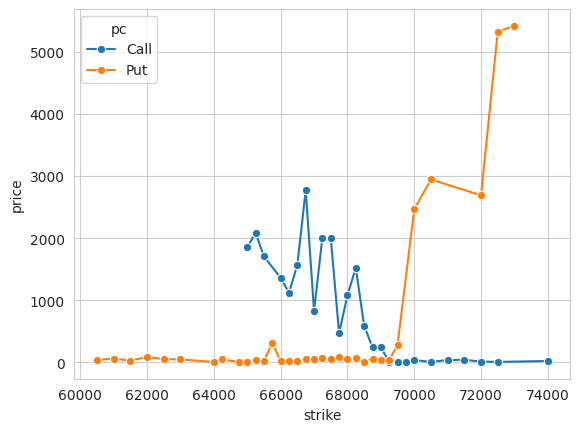

In [12]:
sns.set_style("whitegrid")
sns.lineplot(data=prices, x='strike', y='price', hue='pc', marker='o')

<Axes: xlabel='strike', ylabel='iv'>

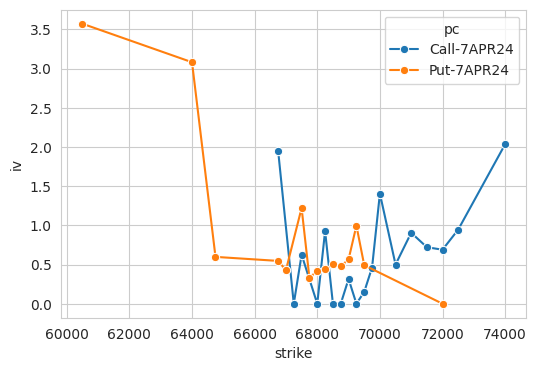

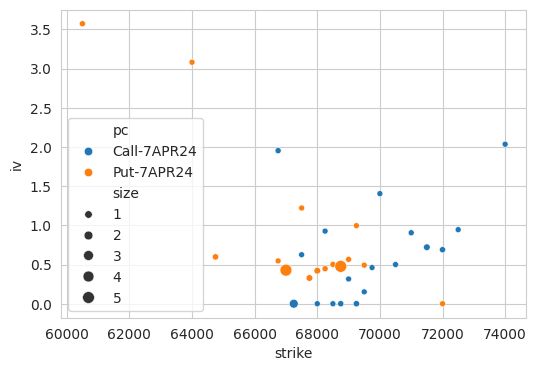

In [13]:
vol = prices.assign(datetime = lambda df: df['datetime'].dt.round('min'))
vol = pd.merge(vol, spot_prices)
# Bybit IV
fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(data=vol.assign(pc = lambda df: df['pc']+'-'+df['symbol'].apply(lambda x: x.split('-')[1])), 
             x='strike', y='iv', hue='pc', marker='o', ax=ax)

# Bybit IV
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=vol.assign(pc = lambda df: df['pc']+'-'+df['symbol'].apply(lambda x: x.split('-')[1])), 
                x='strike', y='iv', hue='pc', size='size', marker='o', ax=ax)